In [ ]:
%matplotlib inline


# Using t-tests
In this tutorial we demonstrate how to check if values are significantly different 
from each other using t-tests


In [1]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
#opening data
import os
import pathlib
import warnings  
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [5]:
cd ~

/Users/jamesdavies


In [6]:
cd /Users/jamesdavies/soccermatics

/Users/jamesdavies/soccermatics


## Opening the dataset

First we open the data. For this example we will use WyScout data from 2017/18 Premier League season.  To meet file size requirements of 
Github, we have to open it from different files,
but you can open the file locally from the directory you saved it in. Also, we open the file containing all teams in WyScout database.



In [8]:
#open events
train = pd.DataFrame()
for i in range(13):
    file_name = 'events_England' +'.json'
    path = os.path.join(str(pathlib.Path().resolve()), 'data', 'Wyscout', file_name)
    with open(path) as f:
        data = json.load(f)
    train = pd.concat([train, pd.DataFrame(data)])
    
#open team data
path = os.path.join(str(pathlib.Path().resolve()),"data", 'Wyscout', 'teams.json')
with open(path) as f:
    teams = json.load(f)

teams_df = pd.DataFrame(teams)
teams_df = teams_df.rename(columns={"wyId": "teamId"})

## Preparing the dataset

First, we take out corners. Then, we sum them by team. We also merge it together with team dataframe to keep their names.
Then we repeat the same, but calculate corners taken by each team per game. 



In [9]:
#get corners
corners = train.loc[train["subEventName"] == "Corner"]
#count corners by team
corners_by_team = corners.groupby(['teamId']).size().reset_index(name='counts')
#merge with team name
summary = corners_by_team.merge(teams_df[["name", "teamId"]], how = "left", on = ["teamId"])
#count corners by team by game
corners_by_game = corners.groupby(['teamId', "matchId"]).size().reset_index(name='counts')
#merge with team name
summary2 = corners_by_game.merge(teams_df[["name", "teamId"]], how = "left", on = ["teamId"])

## One-sample one-sided t-test

Imagine that it is established that teams tyoically get 6 corners in a match in
football. City are an attacking team and we might think that they get more corners than
this. Let's start by plotting a distribution of City's corners.




City typically had 97.50  plus/minus 42.61 corners per match in the 2017/18 season.


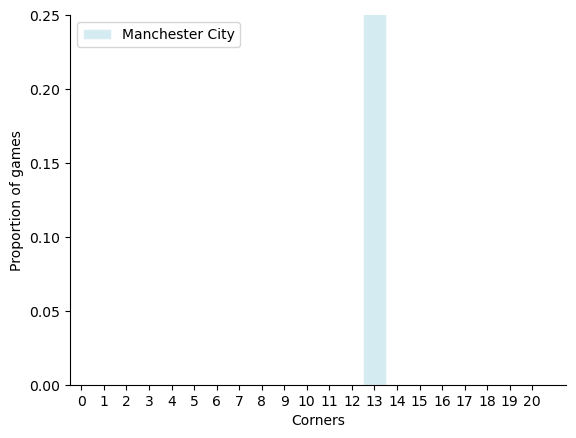

In [10]:
team_name= 'Manchester City'

city_corners = summary2.loc[summary2["name"] == 'Manchester City']["counts"]

def FormatFigure(ax):
    ax.legend(loc='upper left')
    ax.set_ylim(0,0.25) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('Corners')
    ax.set_ylabel('Proportion of games')
    ax.set_xticks(np.arange(0,21,step=1)) 

 
fig,ax1=plt.subplots(1,1)
ax1.hist(city_corners, np.arange(0.01,20.5,1), color='lightblue', edgecolor = 'white',linestyle='-',alpha=0.5, label=team_name, density=True,align='right')
FormatFigure(ax1)


mean = city_corners.mean()
std = city_corners.std()

print('City typically had %.2f  plus/minus %.2f corners per match in the 2017/18 season.'%(mean,std))

We use can use a one-sided t-test to check if Manchester City took
more corners than we might expect due to normal variation in the number
of corners we tend to see.  We set the significance level at 0.05.



In [11]:
from scipy.stats import ttest_1samp
t, pvalue = ttest_1samp(city_corners,popmean=6)

print("The t-staistic is %.2f and the P-value is %.2f."%(t,pvalue))
if pvalue < 0.05:
    print("We reject null hypothesis - " + team_name + " typically take more than 6 corners per match.")
else:
    print("We cannot reject null hypothesis - " + team_name + " do not typically take more than 6 corners per match.")

The t-staistic is 13.24 and the P-value is 0.00.
We reject null hypothesis - Manchester City typically take more than 6 corners per match.


At this significance level, there's a reason to reject the null hypothesis. 
It is reasonable to say that City take more corners than what is considered normal for a typical team (i.e. 6).



## Two-sample two-sided t-test

Here we compare Liverpool and Everton in terms of corners per match. 




In [13]:
liverpool_corners = summary2.loc[summary2["name"] == 'Liverpool']["counts"]
everton_corners = summary2.loc[summary2["name"] == 'Everton']["counts"]

mean = liverpool_corners.mean()
std = liverpool_corners.std()
print('Liverpool typically had %.2f plus/minus %.2f corners per match in the 2017/18 season.'%(mean,std))
std_error=std/np.sqrt(len(liverpool_corners))
print('The standard error in the number of corners per match is %.4f'%std_error)

mean = everton_corners.mean()
std = everton_corners.std()
print('Everton typically had %.2f plus/minus %.2f corners per match in the 2017/18 season.'%(mean,std))
std_error=std/np.sqrt(len(everton_corners))
print('The standard error in the number of corners per match is %.4f'%std_error)

Liverpool typically had 79.03 plus/minus 39.80 corners per match in the 2017/18 season.
The standard error in the number of corners per match is 6.4561
Everton typically had 54.17 plus/minus 34.53 corners per match in the 2017/18 season.
The standard error in the number of corners per match is 5.7558


Now let's plot the corners as a histogram.



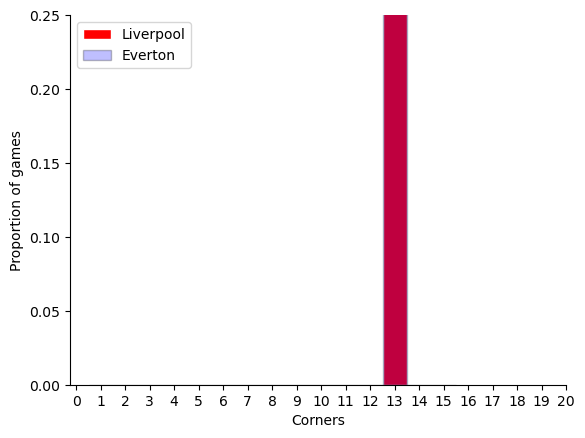

In [14]:
fig,ax=plt.subplots(1,1)
ax.hist(liverpool_corners, np.arange(0.01,15.5,1), color='red', edgecolor = 'white',linestyle='-',alpha=1.0, label="Liverpool", density=True,align='right')
ax.hist(everton_corners, np.arange(0.01,15.5,1), alpha=0.25, color='blue', edgecolor = 'black', label='Everton',  density=True,align='right')
FormatFigure(ax)

In [15]:
# Here we test if Liverpool had a different average corners per game than Everton. 
# We set the significance level at 0.05.


from scipy.stats import ttest_ind
t, pvalue  = ttest_ind(a=liverpool_corners, b=everton_corners, equal_var=True)

print("The t-staistic is %.2f and the P-value is %.2f."%(t,pvalue))
if pvalue < 0.05:
    print("We reject null hypothesis - Liverpool took different number of corners per game than Everton")
else:
    print("We cannot reject the null hypothesis that Liverpool took the same number of corners per game as Everton")

The t-staistic is 2.86 and the P-value is 0.01.
We reject null hypothesis - Liverpool took different number of corners per game than Everton


In [16]:
liverpool_corners

112     39
113     52
114     65
115     39
116    156
117     78
118     65
119     91
120     65
121    117
122     39
123    130
124     91
125    117
126     26
127    156
128     65
129     39
130    104
131     52
132     91
133    117
134     65
135    117
136     52
137     39
138     13
139    104
140    104
141    169
142     78
143     78
144     26
145     91
146     52
147    117
148     13
149     91
Name: counts, dtype: int64

The t-statistic (roughly) measures how many standard errors 
the two means are from each other. 

